
Given the notebook, https://github.com/jpata/particleflow/blob/nb_clic_evaluate/notebooks/mlpf-clic-evaluate.ipynb as it loads the model, sets the weights, run the inference on a  set of events and compare the true vs. Predicted value for pT on a smaller subset.

*Task:*
Do the quantization of the model, and the conversion of the data, all in one notebook along with the model inference. 



Load the quantized model, load the quantized weights, and convert all of the data using quantization and then mesaure the inference

some point you need to use something like tf.lite.TFLiteConverter?
https://www.tensorflow.org/lite/performance/post_training_integer_quant
or is there another way?

In [41]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path += ["../../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [3]:
config, _ = parse_config("../../../../particleflow/parameters/clic.yaml")

In [4]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))


In [5]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  multiple                  33        
 on)                                                             
                                                                 
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [6]:
model.load_weights("../weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)


In [58]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")



In [59]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [60]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)


In [61]:
data = list(tfds.as_numpy(tf_dataset))


In [62]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [63]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [64]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

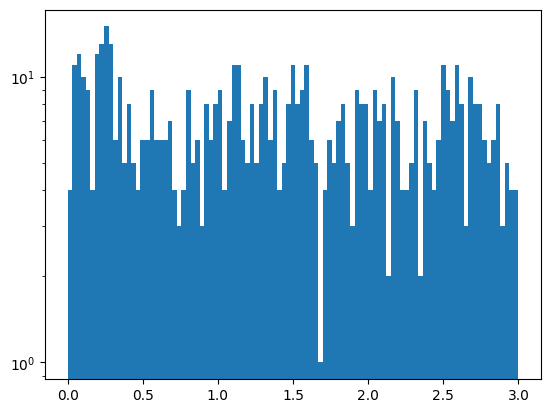

In [65]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

## Quantized data into the unquantized model

Before feeding the input data to the model, we need to quantize it. 

In [66]:
# Quantize input data
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]


In [16]:
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]


In [17]:
ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


In [18]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs_tf[ibatch])

    mask_true_particles = ys_quantized[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [19]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

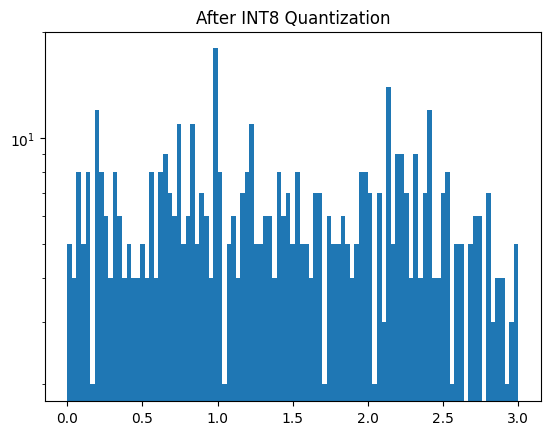

In [20]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.savefig('Output_after_INT8_quantization.png')

Above one is the output with the quantized dataset but not quantized model. We were wokring with the Dynamic Range Quantization. 
Dynamic range quantization is a recommended starting point because it provides reduced memory usage and faster computation without you having to provide a representative dataset for calibration. This type of quantization, statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision.


## Quantized Model with the Quantized Dataset

Let's try with **[quantized model](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization_of_weights_and_activations)**, Post-training qunatization method, Dynamic range quantization. 

## Dynamic Range Quantization

Converting the model using dynamic range quantization(https://www.tensorflow.org/lite/performance/post_training_integer_quant):
Let's enable the default optimizations flag to quantize all fixed parameters (such as weights):
The model is now a bit smaller with quantized weights, but other variable data is still in float format.


In [21]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()


In [22]:
# Measuring the size of the quantized tflite model
# Saving the model
import os

with open('quantized_tflite_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
    
model_size = os.path.getsize('quantized_tflite_model.tflite')

print(f"Size of the quantized model: {model_size} bytes")

Size of the quantized model: 5960536 bytes


In [23]:
# Load the quantized TFlite model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()


In [24]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 111,  17], dtype=int32),
  'shape_signature': array([ -1, 111,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [26]:
# Assuming Xs_quantized is a list of quantized input data
input_data = Xs_quantized[ibatch]

# Print shapes for debugging
print("Input Data Shape:", input_data.shape)
print("Expected Input Shape:", input_details[0]['shape'][1:])


Input Data Shape: (10, 147, 17)
Expected Input Shape: [111  17]


In [39]:
# Assuming you want to use the first 111 samples as a single batch
input_data_reshaped = input_data[:111, :, :]

# Remove the singleton batch dimension
input_data_reshaped = np.squeeze(input_data_reshaped)


# Check the shape after reshaping
print("Reshaped Input Data Shape:", input_data_reshaped.shape)



Reshaped Input Data Shape: (10, 147, 17)


Run the inference on the quantized TFLite model:

In [40]:
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data_reshaped.astype(np.float32))

# Run inference
interpreter.invoke()

ValueError: Cannot set tensor: Dimension mismatch. Got 10 but expected 1 for dimension 0 of input 0.

Let's try with the Full integer quantization 
## Full integer Quantization
Reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by making sure all model math is integer quantized.

For full integer quantization, you need to calibrate or estimate the range, i.e, (min, max) of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. Refer to the `representative_dataset()`function below.


In [28]:
# Define a function to apply Full Integer quantization
def full_integer_quantization(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    return tflite_model

In [30]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")


# Define a function to preprocess the data
def preprocess_data(data):
    # Implement your preprocessing steps here
    return preprocessed_data


In [ ]:
# Process the dataset and run inference with quantized model
true_pts = []
pred_pts = []

for data_batch in tfds.as_numpy(dss):
    X = preprocess_data(data_batch["X"])
    ys = data_batch["ygen"]
    
    # Run inference with the quantized model
    try:
        interpreter = tf.lite.Interpreter(model_content=quantized_model)
        interpreter.allocate_tensors()
        
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        interpreter.set_tensor(input_details[0]['index'], [X])
        interpreter.invoke()
        quantized_output = interpreter.get_tensor(output_details[0]['index'])
        
        mask_true_particles = ys[..., 0] != 0
        true_pt = ys[mask_true_particles, 2]
        pred_pt = quantized_output[0][mask_true_particles][..., 0]
        
        true_pts.extend(true_pt)
        pred_pts.extend(pred_pt)
    except Exception as e:
        print(f"Error processing batch: {e}")


## Float 16 Quantization

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import sys
sys.path += ["../../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [ ]:
config, _ = parse_config("../../../../particleflow/parameters/clic.yaml")

In [ ]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))
model.load_weights("../weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)


In [ ]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)
data = list(tfds.as_numpy(tf_dataset))
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)
    
    
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)


plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

In [68]:
# Convert to float16 quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_float16_tflite_model = converter.convert()


In [70]:
# Quantize the dataset after Assuming Xs is a list of input data
quantized_Xs = [tf.constant(x, dtype=tf.float16) for x in Xs]


In [77]:
# Quantize the model prediction
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in quantized_Xs]


ValueError: Tensor conversion requested dtype float32 for Tensor with dtype float16: <tf.Tensor: shape=(10, 111, 17), dtype=float16, numpy=
array([[[ 1.0000e+00,  6.7891e+00,  4.1528e-01, ..., -6.5002e-02,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  3.7051e+00,  2.9053e-01, ...,  1.7102e-01,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  3.9102e+00,  8.5205e-01, ..., -3.8509e-03,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]],

       [[ 1.0000e+00,  8.8281e+00, -1.6934e+00, ...,  2.6764e-02,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  4.6523e+00,  2.0605e+00, ..., -2.5482e-02,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  3.5859e+00, -2.2539e+00, ...,  5.1361e-02,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]],

       [[ 1.0000e+00,  8.0156e+00,  2.3984e+00, ...,  7.4219e-01,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  2.6660e+00, -1.4648e+00, ..., -8.3923e-02,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.2979e+00,  2.2988e+00, ...,  1.9600e+00,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]],

       ...,

       [[ 1.0000e+00,  1.3891e+01,  1.0059e+00, ...,  1.4854e-02,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  7.9219e+00,  1.1804e-01, ..., -8.1863e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  7.0078e+00,  1.2988e-01, ...,  7.4692e-03,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]],

       [[ 1.0000e+00,  2.8234e+01,  1.1123e+00, ...,  8.6594e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  6.3125e+00,  1.0801e+00, ..., -2.9697e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  5.2969e+00,  1.8896e+00, ...,  6.8542e-02,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]],

       [[ 1.0000e+00,  3.5586e+00,  2.2632e-01, ...,  5.6190e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  2.4609e+00,  1.9495e-01, ...,  8.6288e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  8.3545e-01, -5.4443e-01, ..., -1.4915e-02,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]], dtype=float16)>

In [73]:
quantized_Xs = [tf.constant(x, dtype=tf.float16) for x in Xs]

ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


In [74]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs_tf[ibatch])

    mask_true_particles = ys_quantized[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [75]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

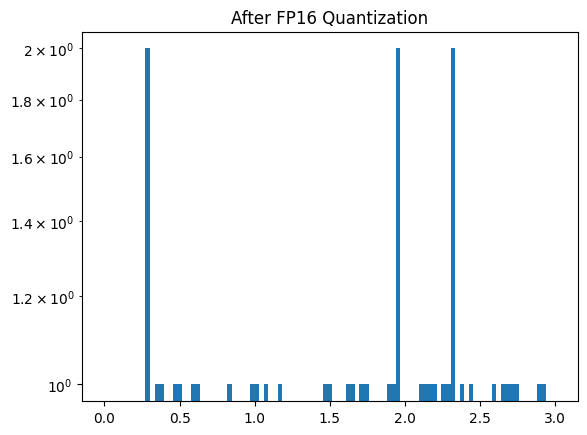

In [76]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.title("After FP16 Quantization")
plt.yscale("log")
# plt.savefig('Output_after_INT8_quantization.png')

**Goal**: \
Target and goal is to convert the model  into the tensorflow quantized model and further after quantizing the dataset measure the inference time. 